In [23]:
import pandas as pd
from pmdarima import auto_arima
from pmdarima.model_selection import train_test_split
import matplotlib.pyplot  as plt
import numpy as np
import pmdarima as pm
from pmdarima.arima import ARIMA
from sklearn.model_selection import ParameterGrid
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import TimeSeriesSplit
import datetime
import requests
import warnings
import matplotlib
import matplotlib.dates as mdates
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
import statsmodels.api as sm
warnings.filterwarnings("ignore")

df = pd.read_csv('multivariate_eng_df.csv', index_col = 'Date', parse_dates = True)
df.head()

,STATE,PROVINCE_STATE_NAME,Completeness_pct,Administered_Dose1_Recip,Administered_Dose1_Recip_5Plus,Administered_Dose1_Recip_12Plus,Administered_Dose1_Recip_18Plus,Administered_Dose1_Recip_65Plus,Series_Complete_Yes,Series_Complete_5Plus,...,vaccination_rate_complete,booster_rate,prop_age04,prop_age59,prop_age6064,prop_age8084,prop_age85plus,AGE04_29_TOT,AGE30_59_TOT,AGE60PLUS_TOT
Date,,,,,,,,,,,,,,,,,,,,,
2020-03-01,6,California,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,5.744418,6.165309,5.818187,1.71647,1.860398,13077768,15818572,8169914
2020-03-02,6,California,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,5.744418,6.165309,5.818187,1.71647,1.860398,13077768,15818572,8169914
2020-03-03,6,California,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,5.744418,6.165309,5.818187,1.71647,1.860398,13077768,15818572,8169914
2020-03-04,6,California,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,5.744418,6.165309,5.818187,1.71647,1.860398,13077768,15818572,8169914
2020-03-05,6,California,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,5.744418,6.165309,5.818187,1.71647,1.860398,13077768,15818572,8169914


In [24]:
#separate df for california -- multivariate still
ca_df = df.loc[df['PROVINCE_STATE_NAME'] == 'California']

In [25]:
#separate univariate dataframe for california
ca_uni_df = ca_df[['PEOPLE_POSITIVE_NEW_CASES_COUNT']]

In [26]:
#separate train & test sets
train_size = int(len(ca_uni_df)* 0.80)
ca_uni_train, ca_uni_test = ca_uni_df[0:train_size], ca_uni_df[train_size:]

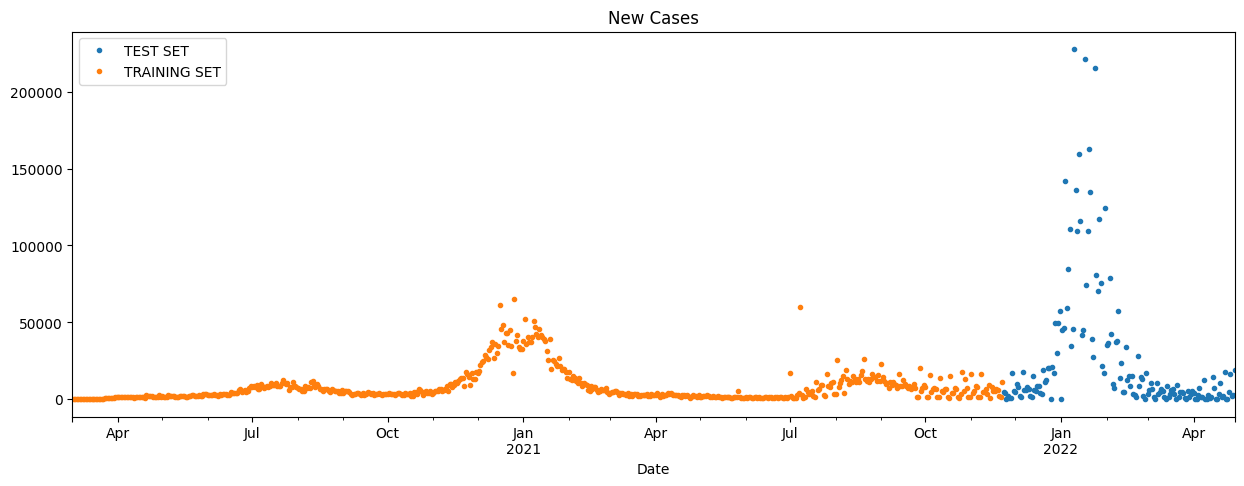

In [27]:
#visualize the 80/20 train/test split
ca_uni_test \
    .rename(columns={'PEOPLE_POSITIVE_NEW_CASES_COUNT': 'TEST SET'}) \
    .join(ca_uni_train.rename(columns={'PEOPLE_POSITIVE_NEW_CASES_COUNT': 'TRAINING SET'}), how='outer')

_ = ca_uni_test \
    .rename(columns={'PEOPLE_POSITIVE_NEW_CASES_COUNT': 'TEST SET'}) \
    .join(ca_uni_train.rename(columns={'PEOPLE_POSITIVE_NEW_CASES_COUNT': 'TRAINING SET'}), how='outer') \
    .plot(figsize=(15,5), title='New Cases', style='.')

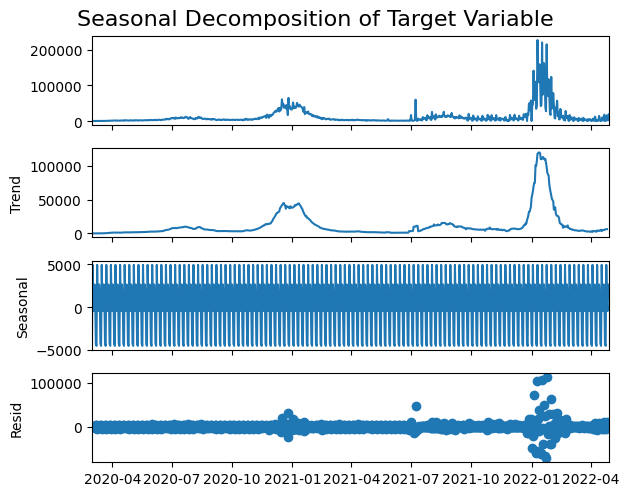

In [28]:
from statsmodels.tsa.seasonal import seasonal_decompose
#seasonal decomposition plot
result = seasonal_decompose(ca_uni_df, period=7)
fig = result.plot()
fig.suptitle('Seasonal Decomposition of Target Variable', fontsize=16, y=1.025)
plt.show()


In [29]:
#baseline seasonal arima model
import statsmodels.api as sm

sarimax = sm.tsa.statespace.SARIMAX(ca_uni_train, order = (1, 1, 1),seasonal_order=(1,1,1,7))
seasonal_model = sarimax.fit()

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.75665D+00    |proj g|=  6.54836D-02

At iterate    5    f=  9.69748D+00    |proj g|=  2.06333D-02

At iterate   10    f=  9.69408D+00    |proj g|=  3.10696D-04

At iterate   15    f=  9.69408D+00    |proj g|=  5.17538D-04

At iterate   20    f=  9.69381D+00    |proj g|=  6.84025D-03

At iterate   25    f=  9.67559D+00    |proj g|=  3.56390D-02

At iterate   30    f=  9.64369D+00    |proj g|=  1.44981D-03

At iterate   35    f=  9.64195D+00    |proj g|=  2.13746D-02

At iterate   40    f=  9.64072D+00    |proj g|=  4.79837D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

In [31]:
#make predictions
predictions_1 = seasonal_model.predict(start=632,end=789,dynamic=True)

#calculate performance metrics
mae = mean_absolute_error(ca_uni_test['PEOPLE_POSITIVE_NEW_CASES_COUNT'], predictions_1)
mse = mean_squared_error(ca_uni_test['PEOPLE_POSITIVE_NEW_CASES_COUNT'], predictions_1)
rmse = np.sqrt(mse)

#naive forecast for mase calculation
naive_forecast = ca_uni_test['PEOPLE_POSITIVE_NEW_CASES_COUNT'].shift(1)
#mae of the naive forecast (excluding first NaN value)
mae_naive = mean_absolute_error(ca_uni_test['PEOPLE_POSITIVE_NEW_CASES_COUNT'][1:], naive_forecast.dropna())
mase = mae / mae_naive

print(f'Mean Absolute Error: {mae}')
print(f'Root Mean Squared Error: {rmse}')
#print(f'Mean Absolute Percent Error: {mape}')
print(f'Mean Absolute Scaled Error: {mase}')

Mean Absolute Error: 23222.332201773836
Root Mean Squared Error: 48737.60755350787
Mean Absolute Scaled Error: 1.1793388984116984


<Axes: xlabel='Date'>

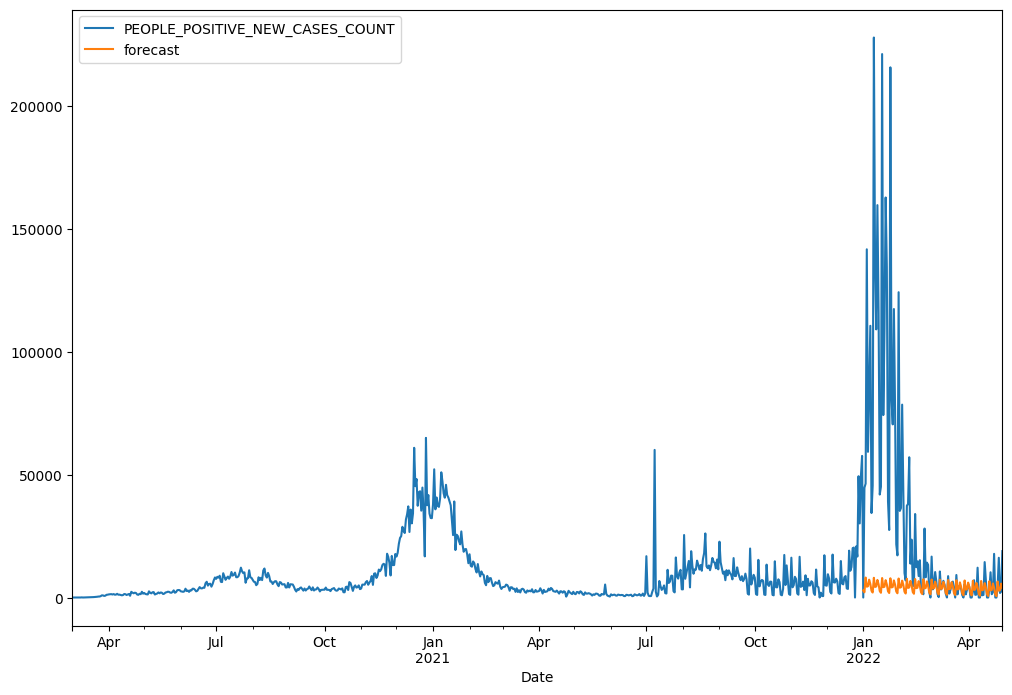

In [32]:
ca_uni_df['forecast']=seasonal_model.predict(start=671,end=790,dynamic=True)
ca_uni_df[['PEOPLE_POSITIVE_NEW_CASES_COUNT','forecast']].plot(figsize=(12,8))

<Axes: title={'center': 'SARIMA Predictions vs. True Test Dataset Values'}, xlabel='Date'>

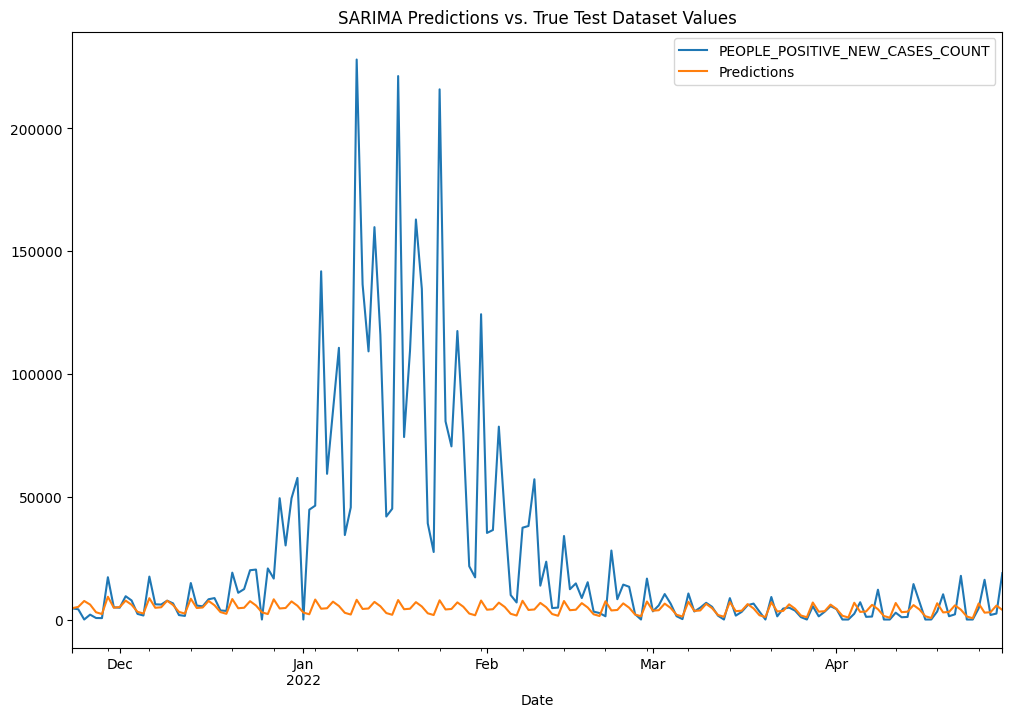

In [33]:
ca_uni_test['Predictions']=seasonal_model.predict(start=632,end=790,dynamic=True)
ca_uni_test[['PEOPLE_POSITIVE_NEW_CASES_COUNT','Predictions']].plot(figsize=(12,8), title='SARIMA Predictions vs. True Test Dataset Values')


In [12]:
#identification -- determine values of p & q
#use gridsearch to select values of p and q -- AIC performance metric
warnings.filterwarnings("ignore")
results=[]
for p in range(1,3):
    for q in range(1,3):
        for P in range(1,3):
            for Q in range(1,3):
                print(p,q,P,Q)
                model=sm.tsa.statespace.SARIMAX(ca_uni_train['PEOPLE_POSITIVE_NEW_CASES_COUNT'],order=(p,1,q), seasonal_order=(P,1,Q,7)).fit()
                results.append([p,q,P,Q,model.aic])  
                
# Create a DataFrame from the results
df_results = pd.DataFrame(results, columns=['p', 'q', 'P', 'Q', 'aic']).sort_values('aic') 

1 1 1 1
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.81717D+00    |proj g|=  5.23195D-02

At iterate    5    f=  9.76351D+00    |proj g|=  1.48545D-02


 This problem is unconstrained.



At iterate   10    f=  9.76122D+00    |proj g|=  3.67265D-04

At iterate   15    f=  9.76122D+00    |proj g|=  3.85670D-04

At iterate   20    f=  9.76118D+00    |proj g|=  5.27786D-03

At iterate   25    f=  9.75697D+00    |proj g|=  4.72068D-02

At iterate   30    f=  9.73019D+00    |proj g|=  7.95661D-03

At iterate   35    f=  9.72822D+00    |proj g|=  6.79160D-03

At iterate   40    f=  9.72812D+00    |proj g|=  1.57108D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     40     43      1     0     0   1.571D-05   9.728D+00
  F =   9.7281218807561860     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f=  9.76201D+00    |proj g|=  7.46627D-03

At iterate   10    f=  9.75967D+00    |proj g|=  1.97394D-03

At iterate   15    f=  9.75964D+00    |proj g|=  1.36533D-04

At iterate   20    f=  9.75964D+00    |proj g|=  5.16578D-04

At iterate   25    f=  9.75952D+00    |proj g|=  5.54288D-03

At iterate   30    f=  9.75336D+00    |proj g|=  1.98980D-02

At iterate   35    f=  9.74249D+00    |proj g|=  1.54296D-02

At iterate   40    f=  9.73823D+00    |proj g|=  1.07472D-03

At iterate   45    f=  9.72842D+00    |proj g|=  2.58288D-02

At iterate   50    f=  9.72576D+00    |proj g|=  1.17522D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  9.78118D+00    |proj g|=  4.82371D-02

At iterate   10    f=  9.75982D+00    |proj g|=  9.71455D-03

At iterate   15    f=  9.75971D+00    |proj g|=  5.83174D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     16     18      1     0     0   5.832D-05   9.760D+00
  F =   9.7597117822382220     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
1 1 2 2


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.78098D+00    |proj g|=  4.83636D-02

At iterate    5    f=  9.76057D+00    |proj g|=  7.05487D-03

At iterate   10    f=  9.76041D+00    |proj g|=  1.27986D-03

At iterate   15    f=  9.75974D+00    |proj g|=  3.77838D-03

At iterate   20    f=  9.75960D+00    |proj g|=  1.40164D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     24     26      1     0     0   5.835D-05   9.760D+00
  F =   9.7595939900708455     

CONVERG

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.81664D+00    |proj g|=  7.46640D-02

At iterate    5    f=  9.75720D+00    |proj g|=  3.34159D-02

At iterate   10    f=  9.75232D+00    |proj g|=  8.48956D-05

At iterate   15    f=  9.75219D+00    |proj g|=  6.33733D-03

At iterate   20    f=  9.75174D+00    |proj g|=  7.19075D-03

At iterate   25    f=  9.75140D+00    |proj g|=  3.71952D-03

At iterate   30    f=  9.75135D+00    |proj g|=  5.16243D-05

At iterate   35    f=  9.75134D+00    |proj g|=  2.37597D-03

At iterate   40    f=  9.74963D+00    |proj g|=  1.71198D-02

At iterate   45    f=  9.73912D+00    |proj g|=  4.61474D-02

At iterate   50    f=  9.73624D+00    |proj g|=  1.24688D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  9.75356D+00    |proj g|=  6.89956D-03

At iterate   10    f=  9.75087D+00    |proj g|=  6.27213D-03

At iterate   15    f=  9.75077D+00    |proj g|=  4.71691D-04

At iterate   20    f=  9.75061D+00    |proj g|=  7.75550D-03

At iterate   25    f=  9.75018D+00    |proj g|=  1.33766D-03

At iterate   30    f=  9.75016D+00    |proj g|=  5.21529D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     30     40      1     0     0   5.215D-05   9.750D+00
  F =   9.7501599188487429     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
1 2 2 1
RUNNING THE L-BFGS-B CODE

           * * *

 This problem is unconstrained.



At iterate    5    f=  9.76810D+00    |proj g|=  7.25195D-02

At iterate   10    f=  9.75094D+00    |proj g|=  8.21753D-03

At iterate   15    f=  9.75081D+00    |proj g|=  3.90421D-04

At iterate   20    f=  9.75073D+00    |proj g|=  9.29642D-03

At iterate   25    f=  9.75028D+00    |proj g|=  4.85273D-03

At iterate   30    f=  9.75025D+00    |proj g|=  1.11724D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     32     36      1     0     0   5.212D-05   9.750D+00
  F =   9.7502507471184394     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
1 2 2 2
RUNNING THE L-BFGS-B CODE

           * * *

 This problem is unconstrained.



At iterate    5    f=  9.75196D+00    |proj g|=  1.00365D-02

At iterate   10    f=  9.75163D+00    |proj g|=  2.84239D-03

At iterate   15    f=  9.75092D+00    |proj g|=  1.32165D-02

At iterate   20    f=  9.75041D+00    |proj g|=  2.68488D-03

At iterate   25    f=  9.75035D+00    |proj g|=  1.06011D-03

At iterate   30    f=  9.75014D+00    |proj g|=  2.57826D-03

At iterate   35    f=  9.75012D+00    |proj g|=  5.21665D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     35     40      1     0     0   5.217D-05   9.750D+00
  F =   9.7501241012747606     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f=  9.76228D+00    |proj g|=  1.19581D-02

At iterate   10    f=  9.76102D+00    |proj g|=  5.25845D-04

At iterate   15    f=  9.76101D+00    |proj g|=  1.51159D-04

At iterate   20    f=  9.76100D+00    |proj g|=  2.48282D-03

At iterate   25    f=  9.75876D+00    |proj g|=  2.67200D-02

At iterate   30    f=  9.72923D+00    |proj g|=  2.39151D-02

At iterate   35    f=  9.72850D+00    |proj g|=  7.29025D-03

At iterate   40    f=  9.72809D+00    |proj g|=  1.51677D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     42     48      1     0     0   6.811D-06   9.728D+00
  F =   9.72809186043

 This problem is unconstrained.



At iterate    5    f=  9.76171D+00    |proj g|=  7.26290D-03

At iterate   10    f=  9.75984D+00    |proj g|=  4.87165D-03

At iterate   15    f=  9.75943D+00    |proj g|=  7.01450D-05

At iterate   20    f=  9.75943D+00    |proj g|=  3.40875D-04

At iterate   25    f=  9.75919D+00    |proj g|=  7.09967D-03

At iterate   30    f=  9.74698D+00    |proj g|=  2.40175D-02

At iterate   35    f=  9.72732D+00    |proj g|=  1.06155D-02

At iterate   40    f=  9.72574D+00    |proj g|=  5.93191D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     43     47      1     0     0   8.340D-06   9.726D+00
  F =   9.72573422603

 This problem is unconstrained.



At iterate    5    f=  9.78097D+00    |proj g|=  7.05008D-02

At iterate   10    f=  9.76009D+00    |proj g|=  8.72045D-03

At iterate   15    f=  9.75952D+00    |proj g|=  1.04894D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     19     23      1     0     0   5.821D-05   9.760D+00
  F =   9.7595123313889829     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2 1 2 2
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.78051D+00    |proj g|=  5.08661D-02


 This problem is unconstrained.



At iterate    5    f=  9.76081D+00    |proj g|=  2.10688D-02

At iterate   10    f=  9.76020D+00    |proj g|=  2.74857D-03

At iterate   15    f=  9.76009D+00    |proj g|=  3.07419D-03

At iterate   20    f=  9.75941D+00    |proj g|=  2.15507D-03

At iterate   25    f=  9.75939D+00    |proj g|=  5.82503D-05

At iterate   30    f=  9.75939D+00    |proj g|=  4.66777D-04

At iterate   35    f=  9.75917D+00    |proj g|=  6.64228D-03

At iterate   40    f=  9.75172D+00    |proj g|=  3.38720D-02

At iterate   45    f=  9.74372D+00    |proj g|=  6.92776D-02

At iterate   50    f=  9.73633D+00    |proj g|=  3.08334D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  9.77889D+00    |proj g|=  5.74829D-02

At iterate   10    f=  9.74764D+00    |proj g|=  8.38969D-03

At iterate   15    f=  9.74738D+00    |proj g|=  4.77316D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     16     18      1     0     0   7.684D-05   9.747D+00
  F =   9.7473815401269714     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2 2 1 2
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.97873D+00    |proj g|=  6.65223D-01


 This problem is unconstrained.



At iterate    5    f=  9.75013D+00    |proj g|=  2.23147D-02

At iterate   10    f=  9.74762D+00    |proj g|=  8.77444D-03

At iterate   15    f=  9.74563D+00    |proj g|=  4.43824D-04

At iterate   20    f=  9.74563D+00    |proj g|=  4.84063D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     20     23      1     0     0   4.841D-05   9.746D+00
  F =   9.7456308981426236     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2 2 2 1
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds


 This problem is unconstrained.



At iterate    5    f=  9.78307D+00    |proj g|=  3.80992D-02

At iterate   10    f=  9.74930D+00    |proj g|=  5.47230D-02

At iterate   15    f=  9.74573D+00    |proj g|=  2.61943D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     18     20      1     0     0   5.327D-05   9.746D+00
  F =   9.7457276912920889     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2 2 2 2
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.00115D+01    |proj g|=  7.05137D-01


 This problem is unconstrained.



At iterate    5    f=  9.75317D+00    |proj g|=  3.12614D-02

At iterate   10    f=  9.74653D+00    |proj g|=  3.34812D-03

At iterate   15    f=  9.74645D+00    |proj g|=  4.24200D-03

At iterate   20    f=  9.74568D+00    |proj g|=  8.62836D-03

At iterate   25    f=  9.74559D+00    |proj g|=  8.32429D-05

At iterate   30    f=  9.74559D+00    |proj g|=  2.23545D-04

At iterate   35    f=  9.74557D+00    |proj g|=  1.97864D-03

At iterate   40    f=  9.74553D+00    |proj g|=  2.44227D-03

At iterate   45    f=  9.74539D+00    |proj g|=  4.54539D-03

At iterate   50    f=  9.74521D+00    |proj g|=  1.68219D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

In [13]:
df_results

,p,q,P,Q,aic
1,1,1,1,2,13063.975277
0,1,1,1,1,13065.139564
9,2,1,1,2,13065.935331
8,2,1,1,1,13067.099277
4,1,2,1,1,13078.034422
11,2,1,2,2,13082.156614
13,2,2,1,2,13094.636665
14,2,2,2,1,13094.766562
12,2,2,1,1,13094.986027
15,2,2,2,2,13096.076581


In [34]:
tscv = TimeSeriesSplit(n_splits=5)
results = []

for train_index, test_index in tscv.split(ca_uni_train['PEOPLE_POSITIVE_NEW_CASES_COUNT']):
    train, test = ca_uni_train['PEOPLE_POSITIVE_NEW_CASES_COUNT'][train_index], ca_uni_train['PEOPLE_POSITIVE_NEW_CASES_COUNT'][test_index]
    
    for p in range(1, 3):
        for q in range(1, 3):
            for P in range(1, 3):
                for Q in range(1, 3):
                    try:
                        model = sm.tsa.statespace.SARIMAX(train,
                                                          order=(p, 1, q),
                                                          seasonal_order=(P, 1, Q, 7)).fit(disp=False)
                        aic = model.aic
                        results.append([p, q, P, Q, aic])
                    except:
                        continue

#convert results to df and average AIC values for each parameter combination
df_results = pd.DataFrame(results, columns=['p', 'q', 'P', 'Q', 'aic'])
avg_results = df_results.groupby(['p', 'q', 'P', 'Q']).agg({'aic': 'mean'}).reset_index().sort_values('aic')

best_parameters = avg_results.iloc[0]
print(best_parameters)


p         1.000000
q         1.000000
P         2.000000
Q         1.000000
aic    5760.303311
Name: 2, dtype: float64


In [36]:
#optimal SARIMA model revealed via gridsearch with AIC for performance evaluation
#train model
sarimax_1=sm.tsa.statespace.SARIMAX(ca_uni_train['PEOPLE_POSITIVE_NEW_CASES_COUNT'],order=(1,1,1), seasonal_order=(2,1,1,7)).fit()

#make predictions
predictions_1 = sarimax_1.predict(start=632,end=789,dynamic=True)

#calculate performance metrics
mae = mean_absolute_error(ca_uni_test['PEOPLE_POSITIVE_NEW_CASES_COUNT'], predictions_1)
mse = mean_squared_error(ca_uni_test['PEOPLE_POSITIVE_NEW_CASES_COUNT'], predictions_1)
rmse = np.sqrt(mse)

#naive forecast for mase calculation
naive_forecast = ca_uni_test['PEOPLE_POSITIVE_NEW_CASES_COUNT'].shift(1)
#mae of the naive forecast (excluding first NaN value)
mae_naive = mean_absolute_error(ca_uni_test['PEOPLE_POSITIVE_NEW_CASES_COUNT'][1:], naive_forecast.dropna())
mase = mae / mae_naive

print(f'Mean Absolute Error: {mae}')
print(f'Root Mean Squared Error: {rmse}')
print(f'Mean Absolute Scaled Error: {mase}')

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.74651D+00    |proj g|=  7.80267D-02

At iterate    5    f=  9.71046D+00    |proj g|=  5.58230D-02

At iterate   10    f=  9.69332D+00    |proj g|=  3.24279D-03

At iterate   15    f=  9.69320D+00    |proj g|=  7.28392D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     15     17      1     0     0   7.284D-05   9.693D+00
  F =   9.6931983619100297     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Mean Abs

AUTO-ARIMA

In [40]:
from pmdarima import auto_arima
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt

auto_model = auto_arima(ca_uni_train, seasonal=True, m=7, suppress_warnings=True, stepwise=True)

n_periods = len(ca_uni_test)
forecast, conf_int = auto_model.predict(n_periods=n_periods, return_conf_int=True)

In [43]:
mae_model = mean_absolute_error(ca_uni_test['PEOPLE_POSITIVE_NEW_CASES_COUNT'], forecast)

rmse_model = sqrt(mean_squared_error(ca_uni_test['PEOPLE_POSITIVE_NEW_CASES_COUNT'], forecast))

naive_forecast = ca_uni_test.shift(1)
mae_naive = mean_absolute_error(ca_uni_test[1:], naive_forecast.dropna())
mase = mae_model / mae_naive

print(f"MAE: {mae_model:.4f}")
print(f"RMSE: {rmse_model:.4f}")
print(f"MASE: {mase:.4f}")

MAE: 23488.3762
RMSE: 48583.8381
MASE: 2.1125


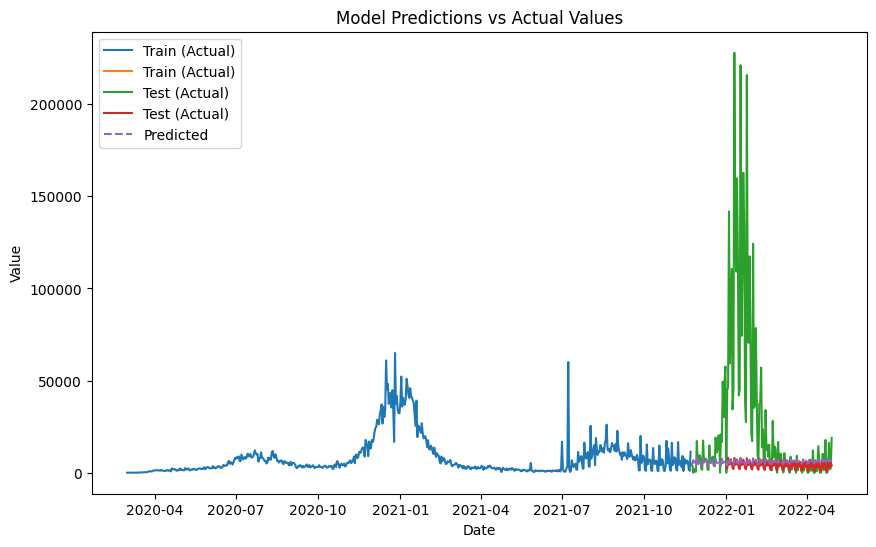

In [44]:
#split data into train and test sets
train = ca_uni_df[:-n_periods]
test = ca_uni_df[-n_periods:]

plt.figure(figsize=(10, 6))
plt.plot(train.index, train, label='Train (Actual)') #train data
plt.plot(test.index, test, label='Test (Actual)') #test data
plt.plot(test.index, forecast, label='Predicted', linestyle='--') #plot predictions

plt.title('Model Predictions vs Actual Values')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

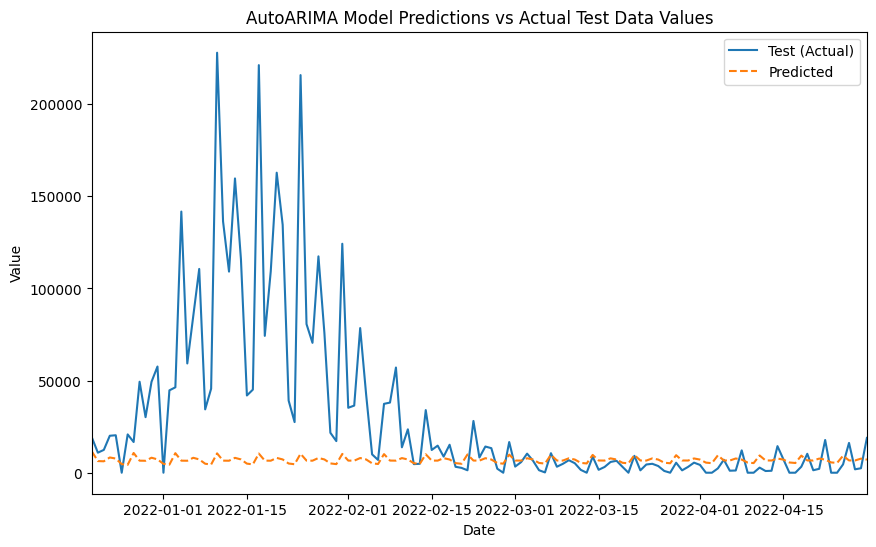

In [35]:
train = ca_uni_df[:-n_periods]
test = ca_uni_df[-n_periods:]


plt.figure(figsize=(10, 6))

plt.plot(test.index, test, label='Test (Actual)')
plt.plot(test.index, forecast, label='Predicted', linestyle='--')

plt.xlim(test.index[0], test.index[-1])

plt.title('AutoARIMA Model Predictions vs Actual Test Data Values')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()